In [1]:
import datetime
import numpy as np

In [2]:
dt32 = np.dtype(np.uint32).newbyteorder('<')
dt16 = np.dtype(np.uint16).newbyteorder('<')

In [3]:
class ldhead(object):
    """Parses and stores the header information of an ld file"""
    def __init__(self, f_):
        # type: (str) -> None
        with open(f_, 'rb') as f:
            f.seek(0x8)

            # meta_ptr: pointer to begin of channel meta info
            # data_ptr: pointer to begin of channel data
            self.meta_ptr, self.data_ptr = np.fromfile(f, dtype=dt32, count=2)

            f.seek(0x14, 1) # jump over unknown
            # pointer to some text
            descr_ = np.fromfile(f, dtype=dt32, count=1)[0]

            f.seek(0x36, 1)
            date = decode_string(f.read(0x10))

            f.seek(0x10,1)
            time = decode_string(f.read(0x10))

            f.seek(0x10,1)
            self.name = decode_string(f.read(0x40))
            self.vehicle = decode_string(f.read(0x40))

            f.seek(0x40,1)
            self.venue = decode_string(f.read(0x40))

            f.seek(descr_)
            self.event = decode_string(f.read(0x10))

            f.seek(0x470, 1)
            descr_ = np.fromfile(f, dtype=dt32, count=1)[0]

            self.descr = None
            if descr_>0:
                f.seek(descr_)
                self.descr = decode_string(f.read(0x10))

            if len(self.vehicle)==0:
                f.seek(0x6e2)
                self.vehicle = decode_string(f.read(0x40))

        try:
            self.datetime = datetime.datetime.strptime(
                    '%s %s'%(date, time), '%d/%m/%Y %H:%M:%S')
        except ValueError:
            self.datetime = datetime.datetime.strptime(
                '%s %s'%(date, time), '%d/%m/%Y %H:%M')

    def __str__(self):
        return 'name:    %s\n' \
               'vehicle: %s\n' \
               'venue: %s\n' \
               'event:   %s descr: %s\n'%(
            self.name, self.vehicle, self.venue, self.event, self.descr)

In [4]:
class ldchan(object):
    """Channel (meta) data

    Parses and stores the channel meta as well as the
    actual data of a channel in a ld file.
    Needs the pointer to the channel meta block in the ld file.
    """
    def __init__(self, f_, meta_ptr, num):
        # type: (str, int, int) -> None
        self.meta_ptr = meta_ptr
        self.num = num

        with open(f_,'rb') as f:
            f.seek(meta_ptr)

            (self.prev_meta_ptr, self.next_meta_ptr, self.data_ptr, self.data_len) =  \
                np.fromfile(f, dtype=dt32, count=4)

            f.seek(2, 1) # some count, not needed?

            dtype_a, dtype, self.freq = np.fromfile(f, dtype=dt16, count=3)
            if dtype_a == 0x07:
                self.dtype = [None, np.float16, None, np.float32][dtype-1]
            else:
                self.dtype = [None, np.int16, None, np.int32][dtype-1]

            self.shift, self.u1, self.scale, self.dec = \
                np.fromfile(f, dtype=np.int16, count=4)#.astype(np.int32)

            self.name = decode_string(f.read(0x20))
            self.short_name = (decode_string(f.read(0x8)))
            self.unit = decode_string(f.read(0xc))

            self.u2, self.u3, self.u4, self.u5 = \
                np.fromfile(f, dtype=np.int16, count=4)#.astype(np.int32)

            # print_hex(f.read(28))

            # jump to data and read
            f.seek(self.data_ptr)
            try:
                self.data = np.fromfile(f,
                    count=self.data_len, dtype=self.dtype)

                self.data = self.data/self.scale * pow(10.,-self.dec) + self.shift

                if len(self.data)!=self.data_len:
                    raise ValueError("Not all data read!")

            except ValueError as v:
                print(v, self.num, self.name, self.freq,
                      hex(self.data_ptr), hex(self.data_len),
                      hex(len(self.data)),hex(f.tell()))
                # raise v

    def __str__(self):
        return 'chan %i: %s (%s) [%s], %i Hz'%(
            self.num, self.name,
            self.short_name, self.unit,
            self.freq)

In [5]:
def print_hex(bytes_, dtype=dt32):
    # type: (bytes, np.dtype) -> None
    """print the bytes as list of hex values
    """
    print(list(map(hex, np.frombuffer(bytes_, dtype=dtype))))

In [6]:
def decode_string(bytes):
    # type: (bytes) -> str
    """decode the bytes and remove trailing zeros
    """
    return bytes.decode('ascii').rstrip('\0').strip()

In [7]:
def read_channels(f_, meta_ptr):
    # type: (str, int) -> list
    """ Read channel data inside ld file

    Cycles through the channels inside an ld file,
     starting with the one where meta_ptr points to.
     Returns a list of ldchan objects.
    """
    chans = []
    while meta_ptr:
        chan_ = ldchan(f_, meta_ptr, len(chans))
        chans.append(chan_)
        meta_ptr = chan_.next_meta_ptr
    return chans

In [8]:
def read_ldfile(f_):
    # type: (str) -> (ldhead, list)
    """ Read an ld file, return header and list of channels
    """
    head_ = ldhead(f_)
    chans = read_channels(f_, head_.meta_ptr)
    return head_, chans

Sample.ld
name:                                                                   
vehicle: 11A                                                            
venue: Calder                                                         
event:   i2 data day descr: Calder

['chan 0: Air Temp Inlet (Air Tem) [C], 2 Hz', 'chan 1: Brake Temp FL (Brake T) [C], 10 Hz', 'chan 2: Brake Temp RL (Brake T) [C], 10 Hz', 'chan 3: Diff Oil Temp (Diff Oi) [C], 1 Hz', 'chan 4: Eng Oil Temp (Eng Oil) [C], 20 Hz', 'chan 5: Engine Temp (Engine) [C], 1 Hz', 'chan 6: Gbox Oil Temp (Gbox Oi) [C], 1 Hz', 'chan 7: Tyre Temp FL Centre (Tyre Te) [C], 5 Hz', 'chan 8: Tyre Temp FL Inner (Tyre Te) [C], 5 Hz', 'chan 9: Tyre Temp FL Outer (Tyre Te) [C], 5 Hz', 'chan 10: Tyre Temp FR Center (Tyre Te) [C], 20 Hz', 'chan 11: Tyre Temp FR Inner (Tyre Te) [C], 20 Hz', 'chan 12: Tyre Temp FR Outer (Tyre Te) [C], 20 Hz', 'chan 13: Tyre Temp RL (Tyre Te) [C], 5 Hz', 'chan 14: Tyre Temp RR (Tyre Te) [C], 20 Hz', 'chan 15: Baro Pres (B

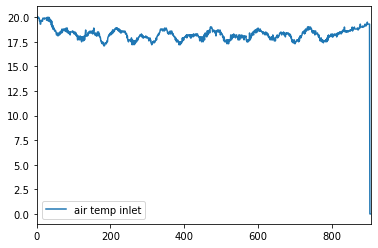

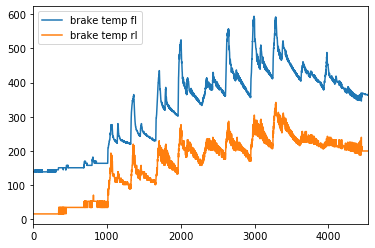

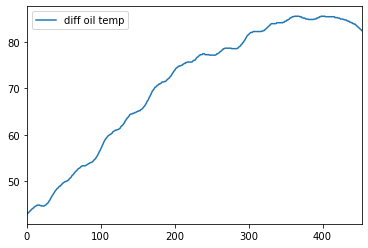

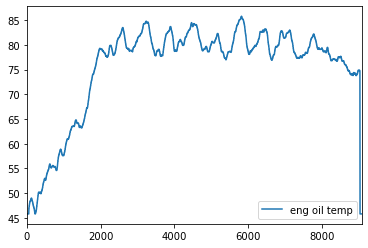

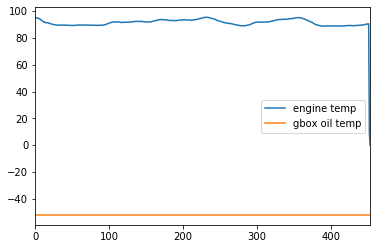

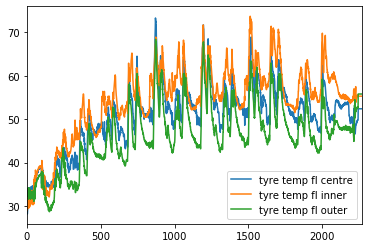

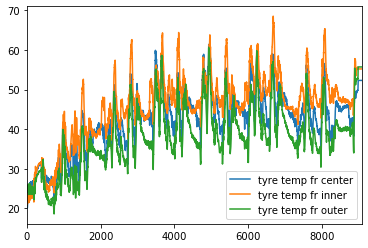

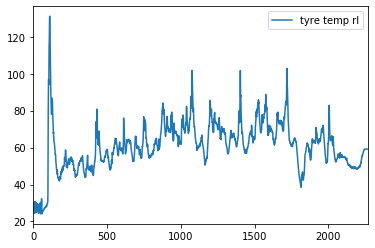

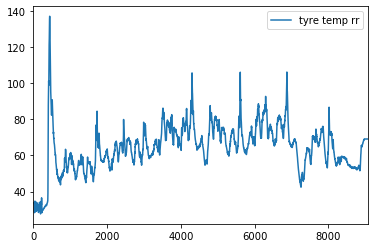

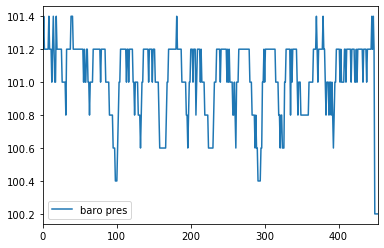

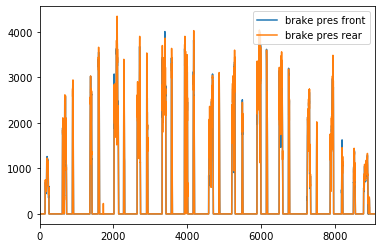

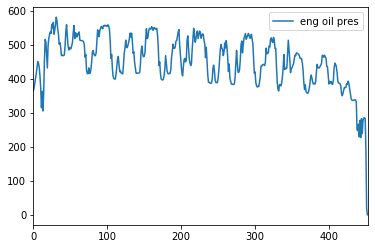

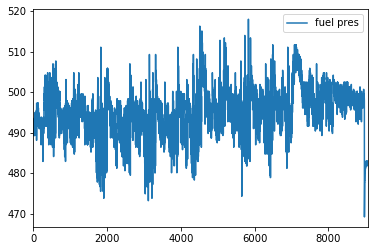

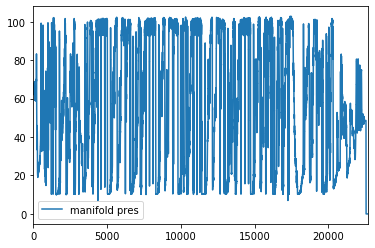

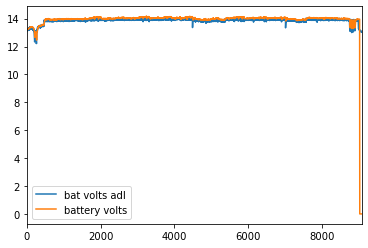

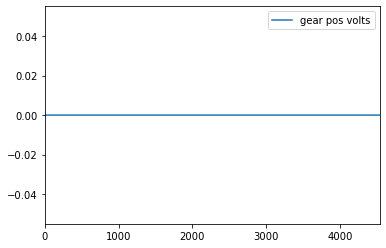

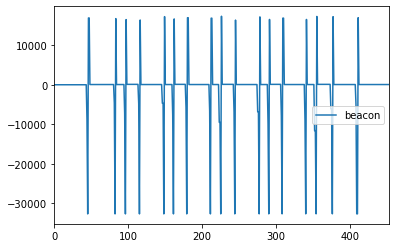

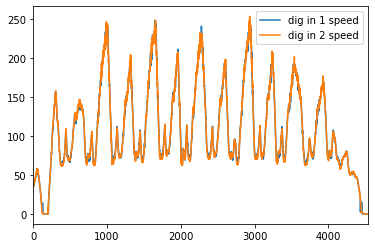

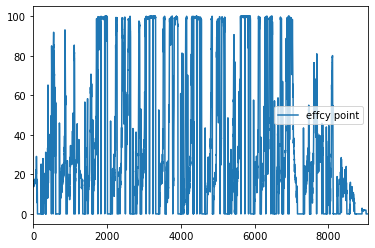

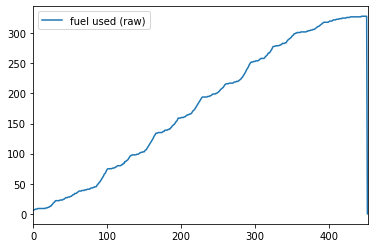

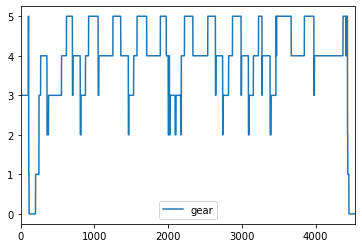

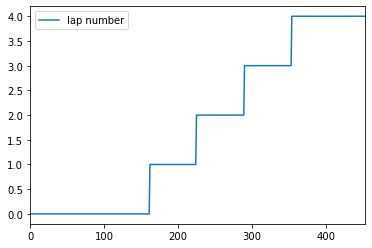

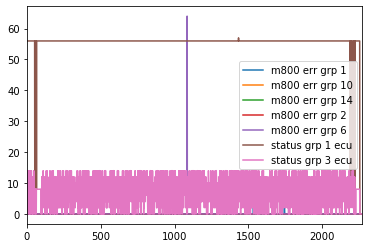

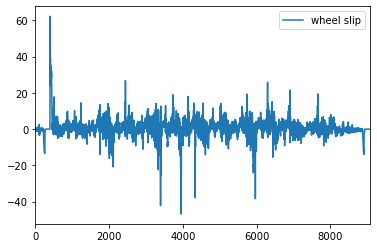

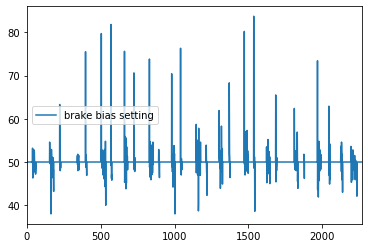

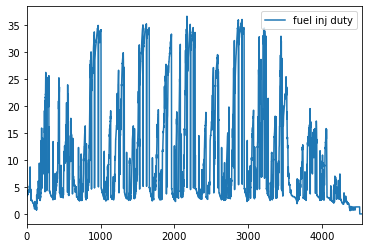

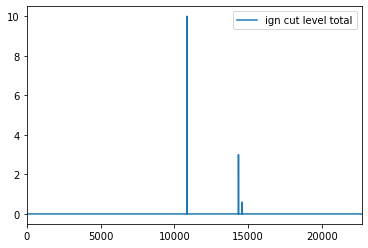

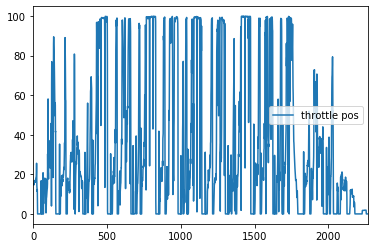

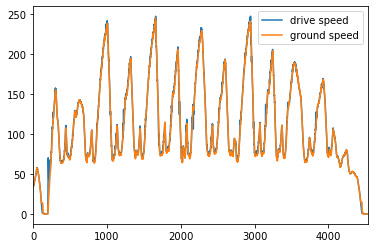

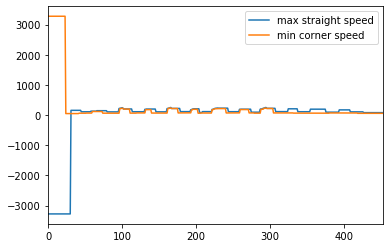

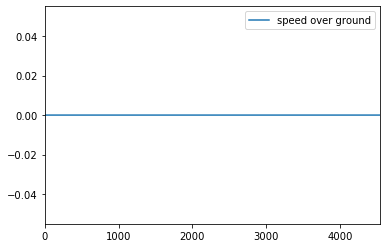

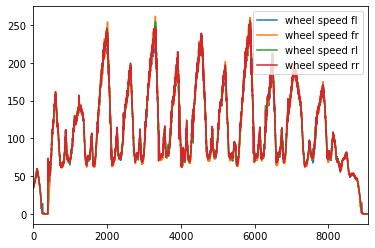

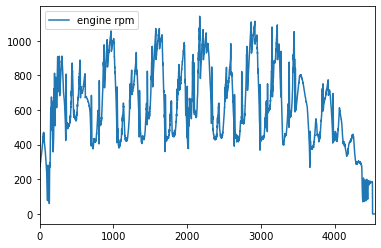

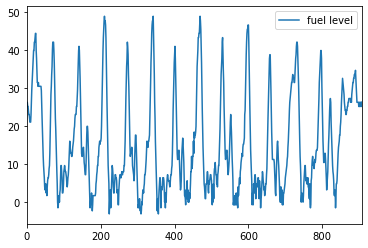

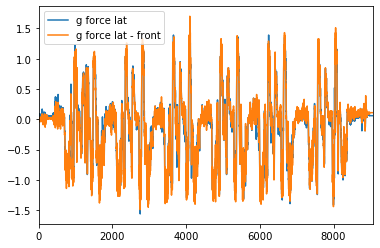

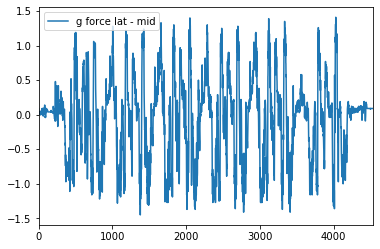

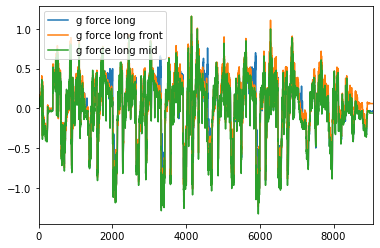

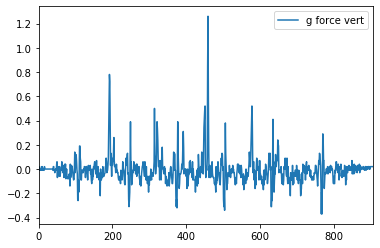

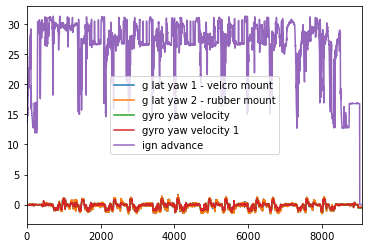

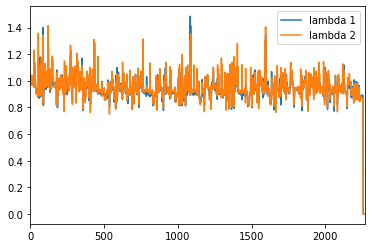

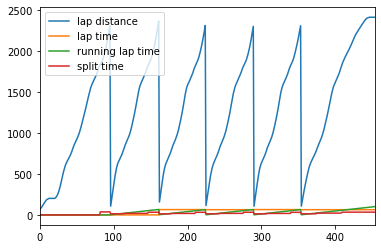

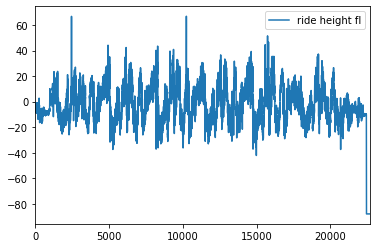

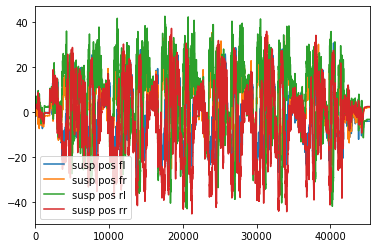

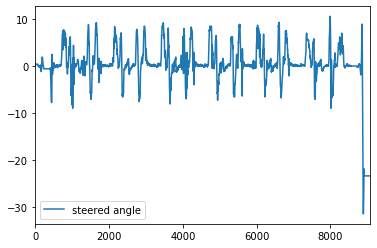

In [9]:
import sys, os, glob
from itertools import groupby
import pandas as pd
import matplotlib.pyplot as plt

for f in glob.glob('%s/*.ld'%"MoTeC"):
    print(os.path.basename(f))
    head_, chans = read_ldfile(f)

    print(head_)
    print(list(map(str,chans)))
    print()

    # create plots for all channels with the same frequency
    for f, g in groupby(chans, lambda x:x.freq):
        df = pd.DataFrame({i.name.lower(): i.data for i in g})
        df.plot()
        plt.show()